In [726]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # Import path effects for text outline
import pandas as pd


In [727]:
def load_task_records(file_path):
    """Load task records from a CSV file."""
    try:
        task_records = pd.read_csv(file_path)
        return task_records
    except Exception as e:
        print(f"Error loading task records: {e}")
        return None

In [728]:
def generate_gantt_arrival_ending_time(task_records):
    # Extract unique GPU IDs from the task records DataFrame
    gpus = task_records['GPU_ID'].unique()
    print(type(gpus))  # Should be a numpy array or similar

    wait_color = 'green'  
    burst_color = 'red'   

    min_start_time = task_records["Start_Time"].min()
    min_arrival_time = task_records["Arrival_Time"].min()

    # Iterate over GPUs to create individual plots
    for g in gpus:
        fig, ax = plt.subplots(figsize=(12, 6))

        # Filter tasks for the current GPU
        gpu_tasks = task_records[task_records['GPU_ID'] == g]

        for i, row in gpu_tasks.iterrows():
            arrival = row['Arrival_Time'] - min_arrival_time
            start = row['Start_Time'] - min_start_time
            training = row['Training_Time']
            user_id = row['User_ID']

            wait_time = start - arrival  # Calculate wait time

            # Plot wait time segment
            if wait_time > 0:  # Ensure wait time is positive
                ax.barh(y=i, width=wait_time, left=arrival, color=wait_color, edgecolor='black', align="center")

            # Plot burst time segment (training time)
            ax.barh(y=i, width=training, left=start, color=burst_color, edgecolor='black', align="center")

            # Center the user ID label on the burst time bar
            mid_point = start + training / 2
            # text = ax.text(mid_point, i, f"User {user_id}", va='center', ha='center', color='black', fontsize=8)

            # Apply white outline around the text
            # text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])
        
        # Configure chart
        ax.set_yticks([])  # Optionally set Y ticks based on tasks if needed
        ax.set_xlabel("Time")
        ax.set_title(f"Gantt Chart of Task Wait and Burst Times for GPU {g}")

        # Add legend for wait and burst time
        handles = [
            plt.Rectangle((0, 0), 1, 1, facecolor=wait_color, edgecolor='black'),
            plt.Rectangle((0, 0), 1, 1, facecolor=burst_color, edgecolor='black')
        ]
        ax.legend(handles, ["Wait Time", "Burst Time"], title="Task Segments", loc='upper right')

        plt.tight_layout()  # Adjust layout to prevent clipping of elements
        plt.show()

# Assuming you have a DataFrame `task_records` already defined
# generate_gantt_arrival_ending_time(task_records)


In [729]:
import pandas as pd
import matplotlib.pyplot as plt

def get_gpus(task_records):
    """Get unique GPU IDs from task records."""
    gpu_ids = []  # Initialize an empty list to store unique GPU IDs

    # Iterate through each record in the task_records DataFrame
    for _, record in task_records.iterrows():  # Corrected to use iterrows
        gpu_id = record['GPU_ID']  # Extract the GPU_ID from the current record

        # Check if this GPU ID is not already in the gpu_ids list
        if gpu_id not in gpu_ids:
            gpu_ids.append(gpu_id)  # Add the unique GPU_ID to the list

    return gpu_ids  # Return the list of unique gpu_ids

def generate_gantt_gantt_executions(task_records):
    gpus = get_gpus(task_records)  # Get unique GPU IDs
    fig, ax = plt.subplots(figsize=(20, 6))

    # Define color based on task duration
    model_names = [
    "google/flan-t5-base",
    "google/flan-t5-small",
    "lucadiliello/bart-small",
    ]
    def get_color(model_name):
        if model_name in model_names:
            if model_name == model_names[0]:
                return (1.0, 0, 0)  # Red for longest duration
            elif model_name == model_names[1]:
                return (1.0, 0.5, 0)  # Orange for below medium
            elif model_name == model_names[2]:
                return (1.0, 1.0, 0)  # Yellow for shortest duration
            
    min_start_time = task_records['Start_Time'].min()

    # Plot each task on the Gantt chart
    for _, row in task_records.iterrows():
        gpu_id = row['GPU_ID']
        start = row['Start_Time'] - min_start_time
        end = row['End_Time']
        duration = row['Training_Time']
        name = row['Model_Name']
        color = get_color(name)
        ax.barh(gpu_id, duration, left=start, color=color, edgecolor='black')

    # Configure chart
    ax.set_yticks(gpus)  # Set Y ticks to GPU IDs
    ax.set_yticklabels([f"GPU {gpu}" for gpu in gpus])  # Label format for GPUs
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart of Task Allocation on GPUs")

    # Create custom legend for duration color coding
    legend_labels = model_names
    legend_colors = [(1.0, 0, 0), (1.0, 0.5, 0), (1.0, 1.0, 0)]  # Colors for each label
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(handles, legend_labels, title="Color Meaning", loc='upper right')

    plt.show()

In [730]:
import numpy as np
def calculate_total_waiting_time(task_records, user_id = None):
    """Calculate the total waiting time across all tasks in a DataFrame."""

    df = task_records

    if user_id != None:
        df = task_records[task_records["User_ID"] == user_id]

    tot_times = []
    checked_ids = []

    for i, row in df.iterrows():
        if row["Task_Retrain"] == -1:
            tot_times += [row["Start_Time"] - row["Arrival_Time"]]
        else:

            if row["Task_Id"] in checked_ids:
                continue

            last_retraing = df[df["Task_Id"] == row["Task_Id"]]
            last_retraing = last_retraing.sort_values(by=['Task_Retrain'])


            last_start_time = last_retraing["Start_Time"].tail(1)
            last_arrival_time = last_retraing["Arrival_Time"].tail(1)

            tot_times += [last_start_time - last_arrival_time]
            checked_ids += [row["Task_Id"]]


    mean_tot_times = np.array(tot_times).mean()
    std_tot_times = np.array(tot_times).std()
    sum_tot_times = np.array(tot_times).sum()

    return (mean_tot_times, std_tot_times, sum_tot_times)


    # # Calculate waiting times
    # task_records['Waiting_Time'] = task_records['Start_Time'] - task_records['Arrival_Time']
    
    # # # Sum the waiting times
    # total_waiting_time = task_records['Waiting_Time'].sum()
    # return total_waiting_time


In [731]:
def plot_waiting_times(task_records):
    fig, ax = plt.subplots(figsize=(10, 6))

    user_ids = list(task_records["User_ID"].unique())
    bar_width = 0.8
    
    # Scale x positions to increase space between clusters
    x = np.arange(len(user_ids)) * 2.5

    for idx, u_id in enumerate(user_ids):
        user_metrics = calculate_total_waiting_time(task_records=task_records, user_id=u_id)

        # Bar plot for average waiting times
        ax.bar(x[idx] - bar_width/2, user_metrics[0], color='blue', alpha=1, label='Average Waiting Time' if idx == 0 else "")

        # Bar plot for total waiting times on top
        ax.bar(x[idx] + bar_width/2, user_metrics[2], color='red', alpha=1, label='Total Waiting Time' if idx == 0 else "")

    ax.set_xlabel('User ID')
    ax.set_ylabel('Waiting Time (seconds)')
    ax.set_title('Waiting Times per User')
    ax.set_xticks(x)
    ax.set_xticklabels(user_ids)
    ax.legend()
    ax.grid(axis='y')
    fig.tight_layout()
    plt.show()

In [732]:
# Load task records from the CSV file
file_path = '../results/task_records_users_10_tasks_3_seed_10_scheduling_fifo_range_0.01_0.1_dare_False_session_True_v2.csv'  # Ensure this matches your saved file name
task_records = load_task_records(file_path)

if task_records is None:
    print("Failed to load task records. Exiting.")

In [733]:
calculate_total_waiting_time(task_records)

(np.float64(26.388702408472696),
 np.float64(21.870970703643593),
 np.float64(791.6610722541809))

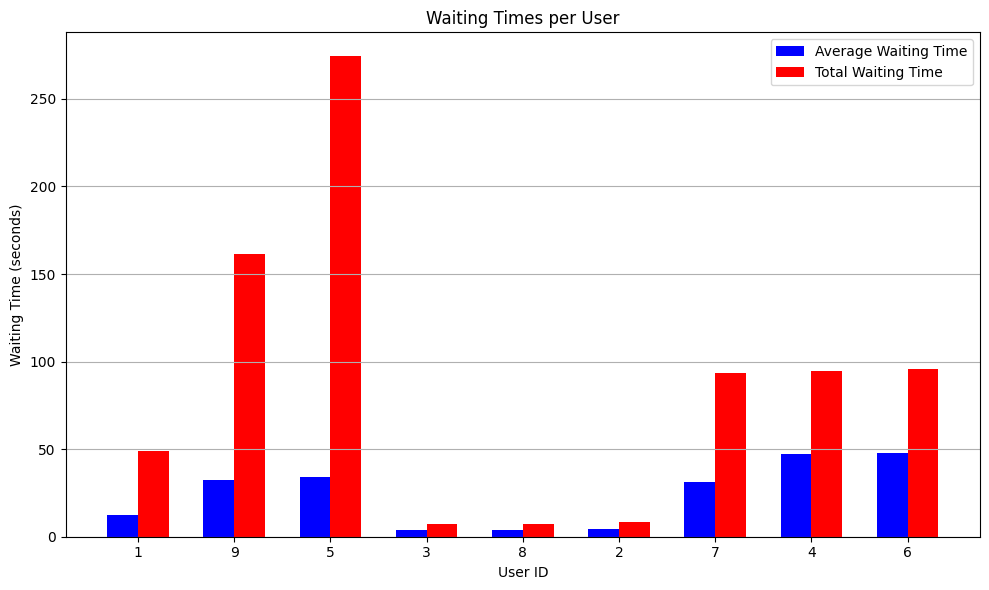

In [734]:
plot_waiting_times(task_records)

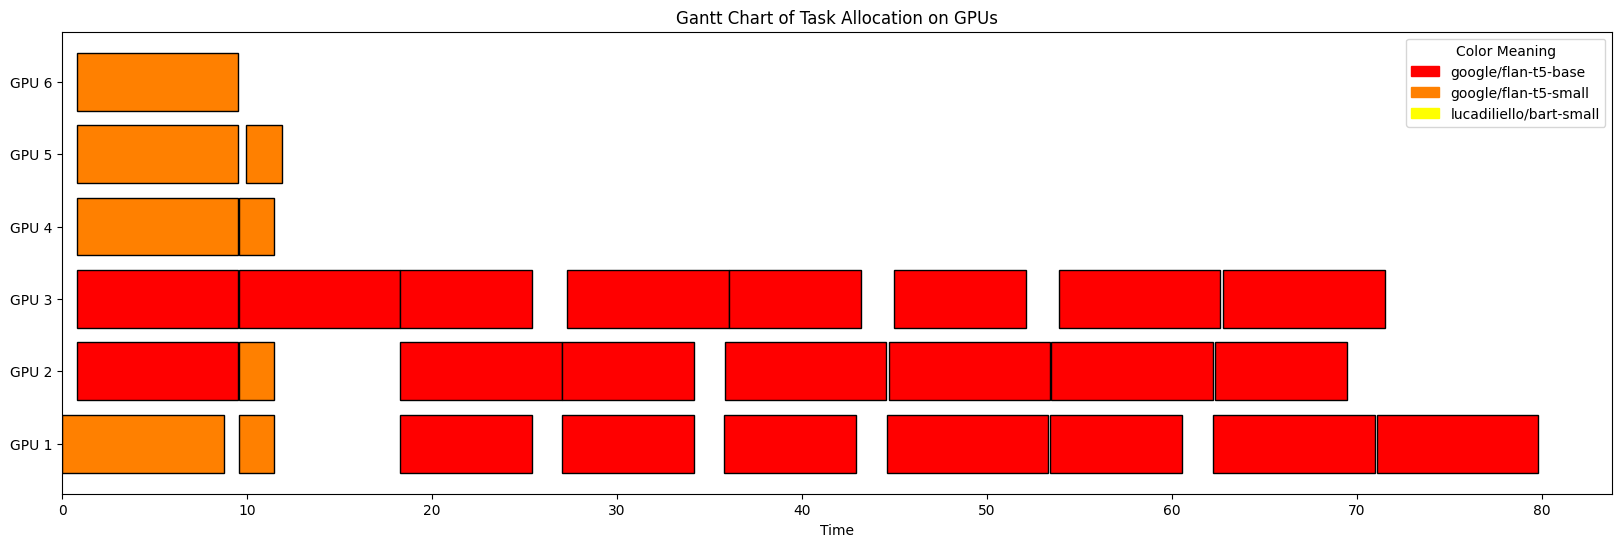

In [735]:
generate_gantt_gantt_executions(task_records)

<class 'numpy.ndarray'>


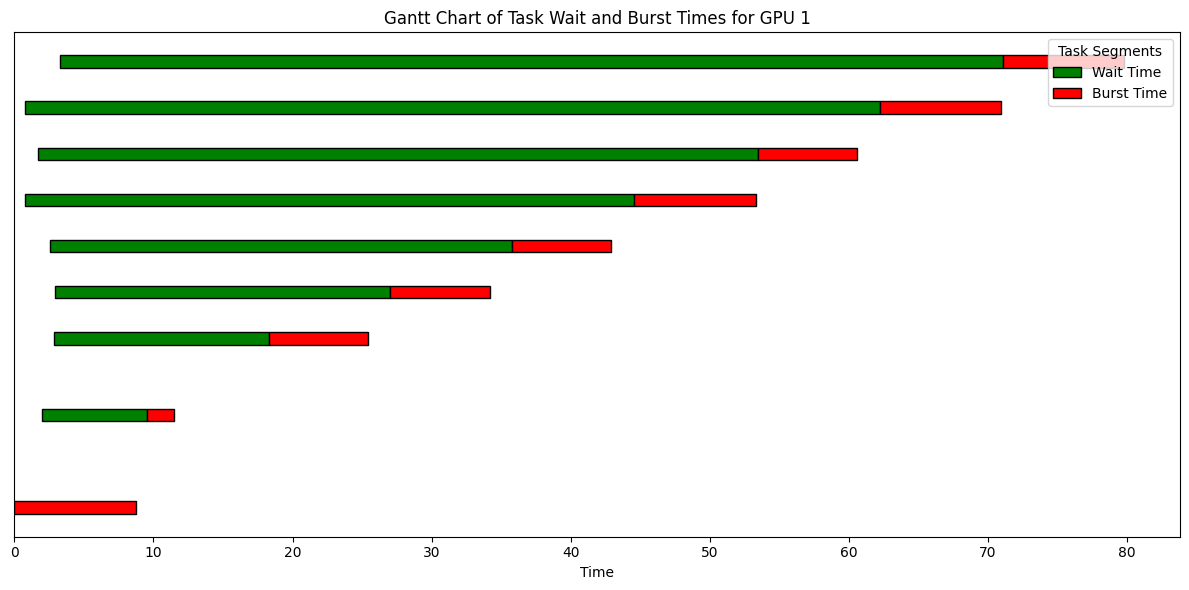

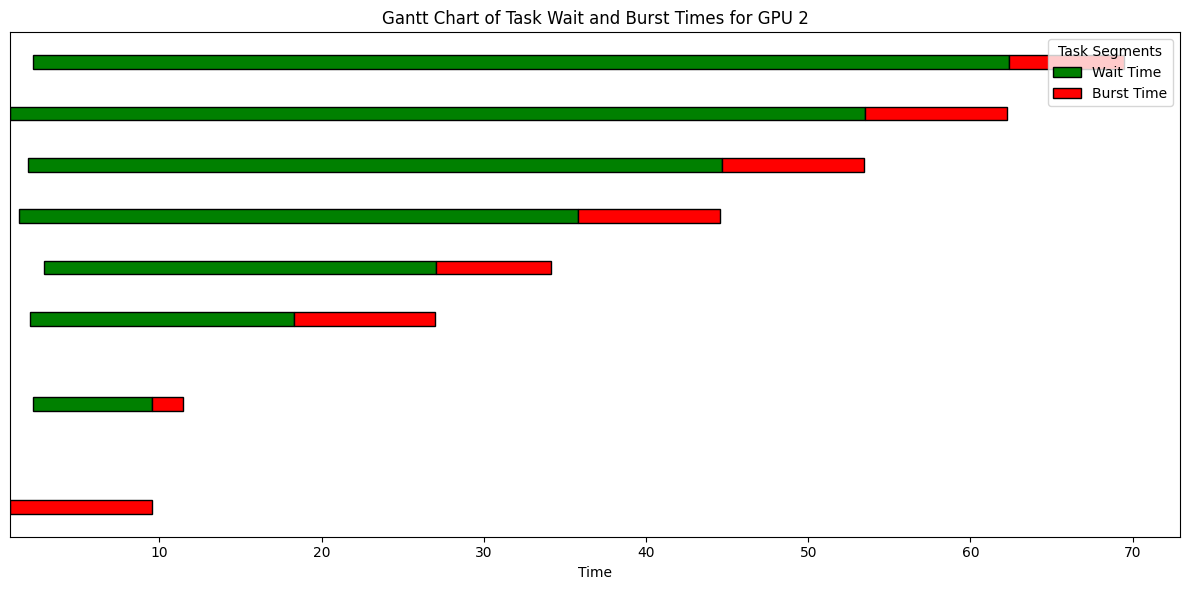

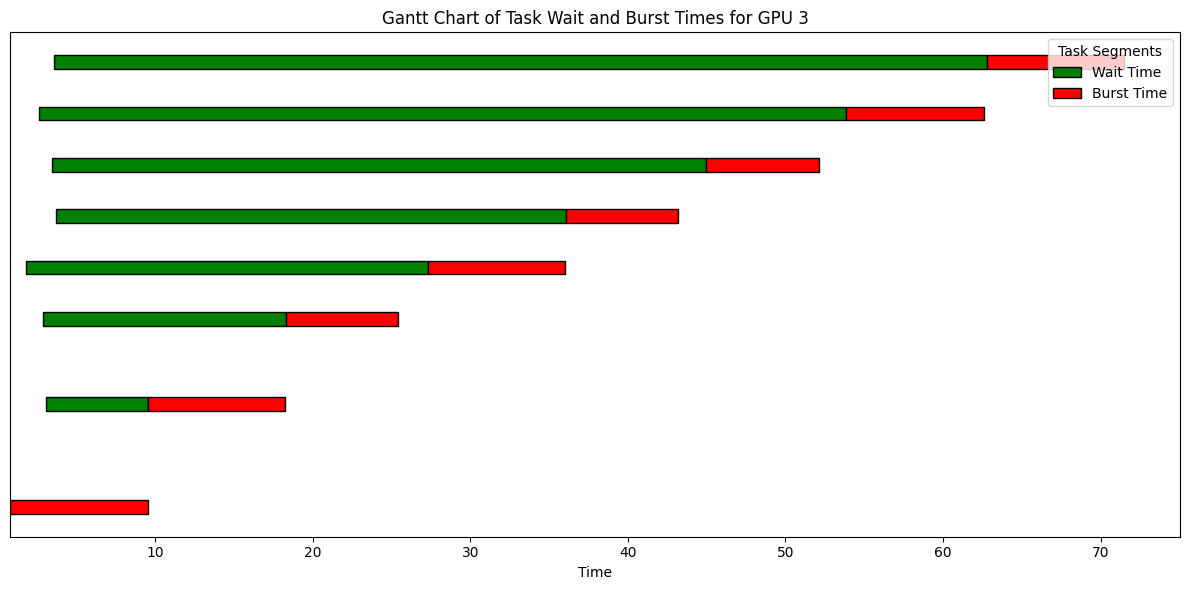

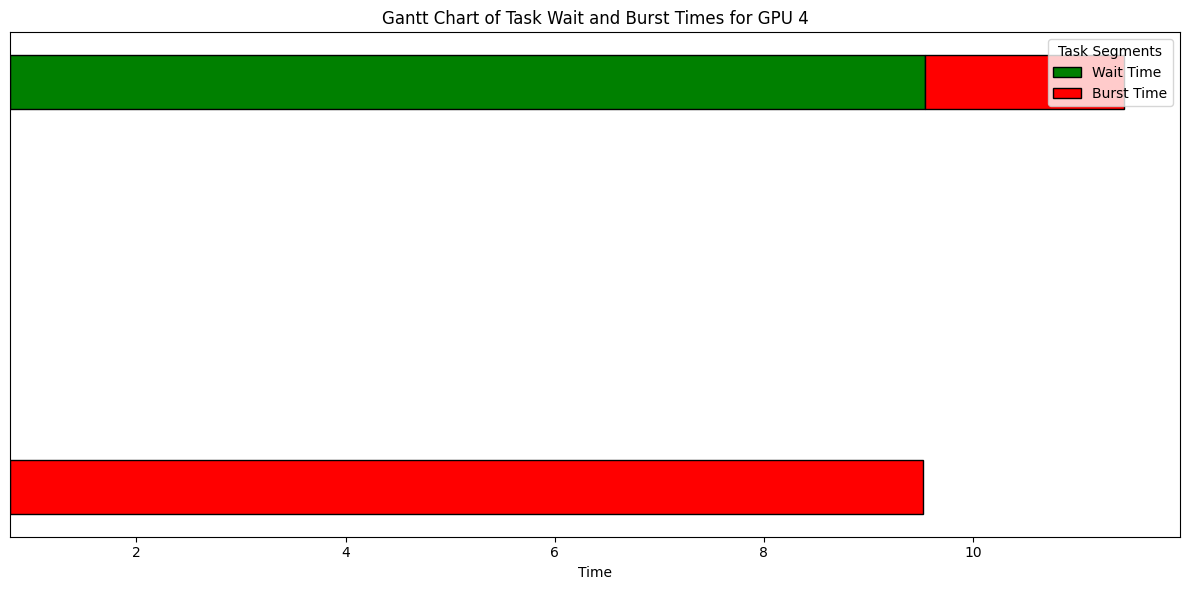

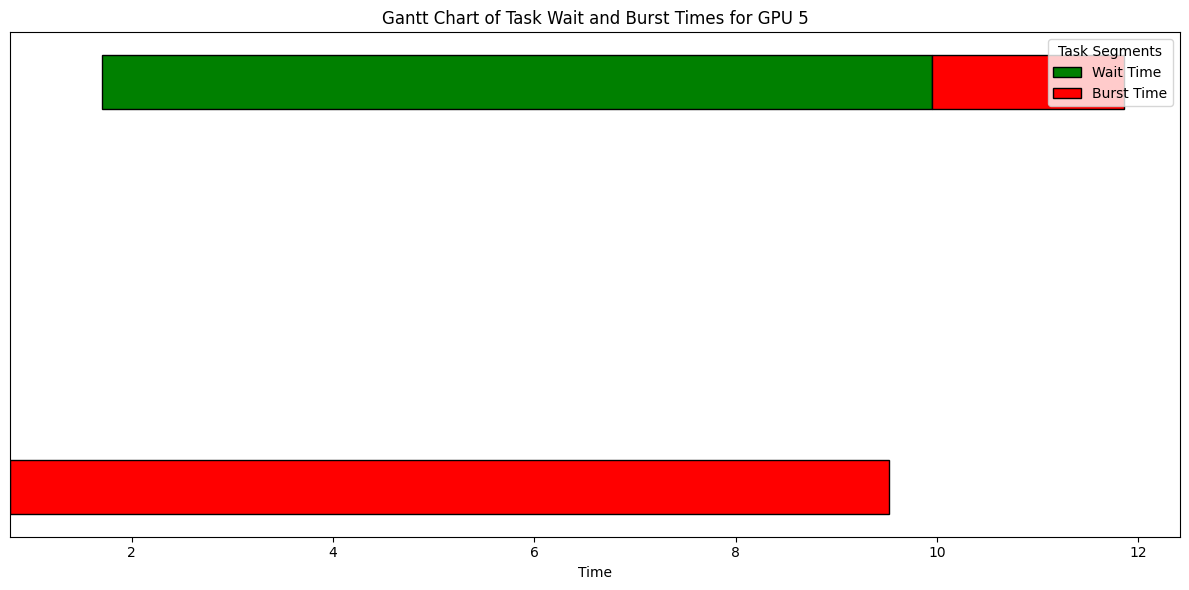

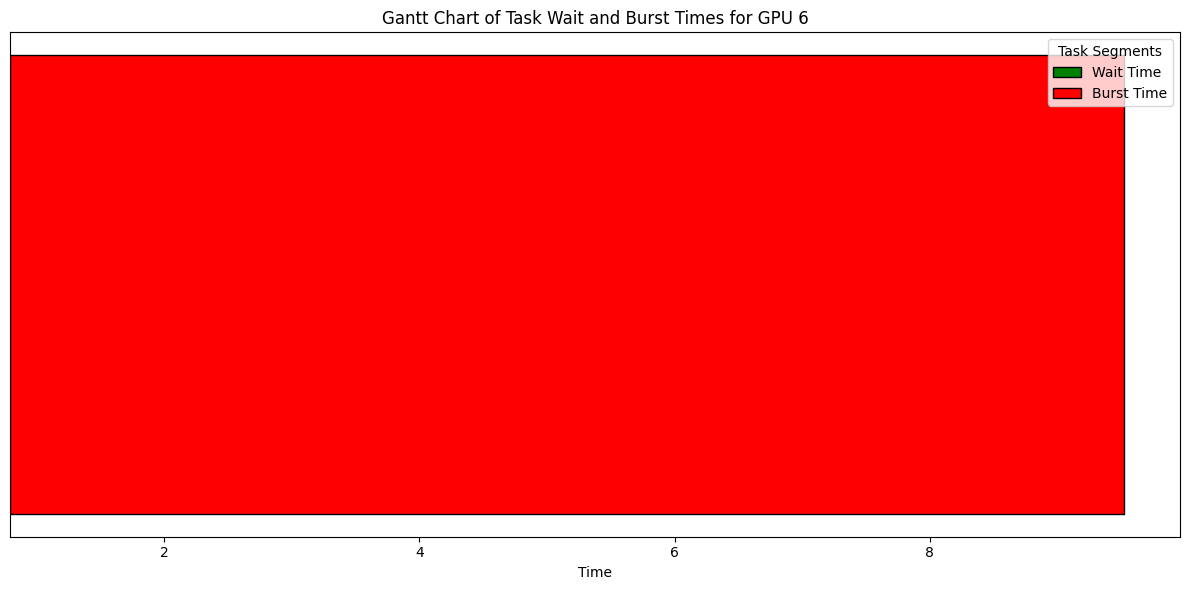

In [736]:
generate_gantt_arrival_ending_time(task_records)